# Importing template refinement results into a `ParticleStack` object

*NOTE: This notebook currently requires files present on the workstation. Need to transfer these to a remote location so any machine can build*

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

from mosaics.data_structures.micrograph import Micrograph
from mosaics.data_structures.particle_stack import ParticleStack
from mosaics.data_structures.contrast_transfer_function import ContrastTransferFunction
from mosaics.filters.whitening_filter import apply_whitening_filter


## Define the reference files path

The variable `images_dir` includes `.mrc` files for the original micrographs which we want to extract, and the `out_coordinates_dir` contains result files from the `refine_template` and `make_template_result` programs from cisTEM.
Converting from the relative defocus paramteres, relative to the micrograph, to abosolute defocus parameters per-particle requires the CTF fit estimations; the variable `ctf_fit_path` is a text file defining this information for each of the micrographs.

In [2]:
images_dir = "/home/shared/lucas_2023_vol1/nrs/lucasb/eLife_submission_April_2022/Images"
ctf_fit_path = "/home/shared/lucas_2023_vol1/groups/lucasb/HRTM/projects/classification_of_60S/TM_results_20220311/defocus.txt"
out_coordinates_dir = "/home/shared/lucas_2023_vol1/groups/lucasb/HRTM/projects/classification_of_60S/TM_results_20220311/0"

### Parse the CTF fit values

Plus other paramteters for the data acquisition are defined below.

In [3]:
# Default other CTF parameters
voltage = 300
spherical_aberration = 2.7
amplitude_contrast_ratio = 0.07
B_factor = 60.0
pixel_size = 1.06
ctf_fits = {}

# Pair each of the micrographs with the corresponding CTF fit
with open(ctf_fit_path, "r") as f:
    for line in f:
        micrograph_id, defocus_1, defocus_2, defocus_angle = line.split()
        defocus_1 = float(defocus_1)
        defocus_2 = float(defocus_2)
        defocus_angle = float(defocus_angle)
        ctf_fits[micrograph_id] = (defocus_1, defocus_2, defocus_angle)

print(f"Loaded {len(ctf_fits)} CTF fits.")

Loaded 28 CTF fits.


### Instantiate the micrograph objects

Each image is loaded into its own `Micrograph` object, and the relavent CTF fit parameters are added to its held `ContrastTransferFunction` object.

In [4]:
micrographs = []

for i, micrograph_path in enumerate(sorted(glob(f"{images_dir}/*.mrc"))):
    # Extract expected micrograph id for indexing the CTF fit dict
    micrograph_id = micrograph_path.split("/")[-1]
    
    # Instantiate the Micrograph object
    micrograph = Micrograph.from_mrc(micrograph_path)
    micrograph.ctf = ContrastTransferFunction(
        voltage=voltage,
        spherical_aberration=spherical_aberration,
        amplitude_contrast_ratio=amplitude_contrast_ratio,
        B_factor=B_factor,
        pixel_size=pixel_size,
        defocus_1=ctf_fits[micrograph_id][0],
        defocus_2=ctf_fits[micrograph_id][1],
        astigmatism_azimuth=ctf_fits[micrograph_id][2],
    )
    
    micrographs.append(micrograph)
    
print(f"Loaded {len(micrographs)} micrographs.")

Loaded 28 micrographs.


### Apply a whitening filter to each of the micrographs

The images are whitened using the global power spectal density rather than adjustments in local regions.
Prevents certain cell features from overpowering the whitening step.

In [5]:
for micrograph in micrographs:
    print(f"Whitening {micrograph.image_path}")
    micrograph.image_array = apply_whitening_filter(micrograph.image_array, pixel_size=micrograph.pixel_size, is_fourier_space=False) 


Whitening /home/shared/lucas_2023_vol1/nrs/lucasb/eLife_submission_April_2022/Images/115_Mar12_10.39.05_93_0.mrc
Whitening /home/shared/lucas_2023_vol1/nrs/lucasb/eLife_submission_April_2022/Images/118_Mar12_10.46.25_99_0.mrc
Whitening /home/shared/lucas_2023_vol1/nrs/lucasb/eLife_submission_April_2022/Images/131_Mar12_11.32.55_127_0.mrc
Whitening /home/shared/lucas_2023_vol1/nrs/lucasb/eLife_submission_April_2022/Images/133_Mar12_11.37.56_131_0.mrc
Whitening /home/shared/lucas_2023_vol1/nrs/lucasb/eLife_submission_April_2022/Images/135_Mar12_11.42.53_135_0.mrc
Whitening /home/shared/lucas_2023_vol1/nrs/lucasb/eLife_submission_April_2022/Images/138_Mar12_11.50.12_141_0.mrc
Whitening /home/shared/lucas_2023_vol1/nrs/lucasb/eLife_submission_April_2022/Images/141_Mar12_11.57.31_147_0.mrc
Whitening /home/shared/lucas_2023_vol1/nrs/lucasb/eLife_submission_April_2022/Images/143_Mar12_12.02.15_151_0.mrc
Whitening /home/shared/lucas_2023_vol1/nrs/lucasb/eLife_submission_April_2022/Images/146_M

## Create `ParticleStack` objects form the out coordinates files

In [8]:
particle_stacks = []
box_size = (384, 384)

for i, micrograph in enumerate(micrographs):
    # Extract the micrograph id from the out coordinates file path
    micrograph_id = micrograph.image_path.split("/")[-1][:-4]
    out_coordinates_file = f"{out_coordinates_dir}/{micrograph_id}_out_coordinates.txt"
    
    tmp_particle_stack = ParticleStack.from_out_coordinates_and_micrograph(
        out_coordinates_path=out_coordinates_file,
        micrograph=micrograph,
        box_size=box_size,
        positions_reference="center",
        handle_bounds="fill",
    )
    
    particle_stacks.append(tmp_particle_stack)
    
print(f"Loaded {len(particle_stacks)} particle stacks.")

Loaded 28 particle stacks.


## Plot views of each of the particles

Plotting 36 particles in a 6 x 6 grid.


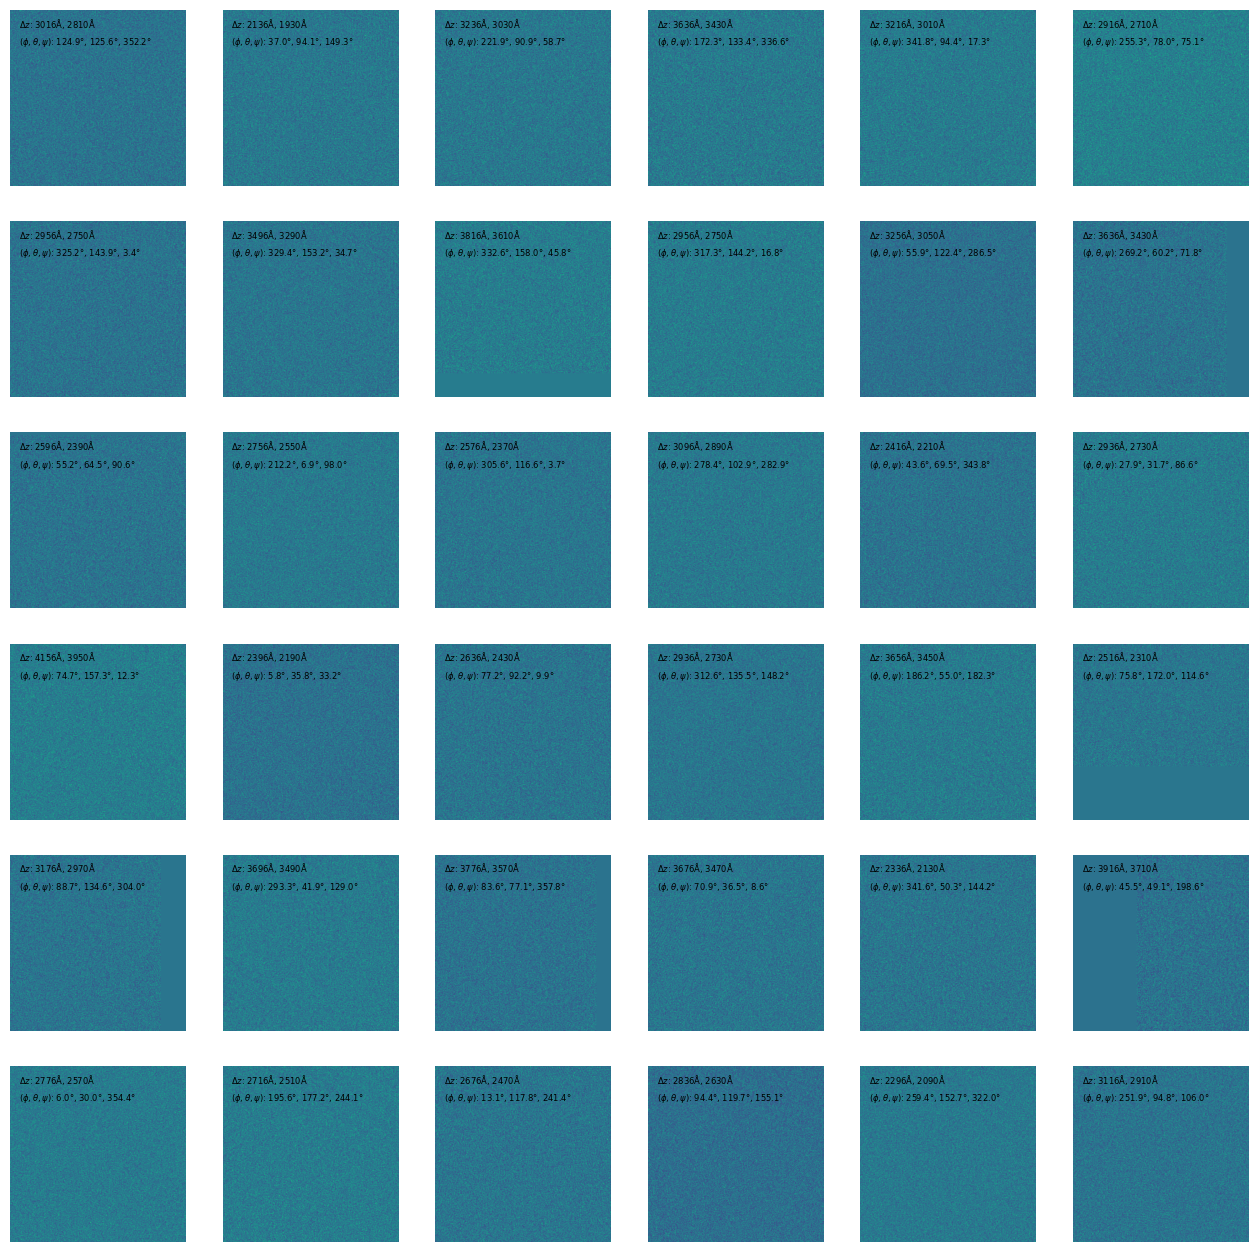

In [13]:
particle_stack = particle_stacks[0]

# Calculate optimal grid dimensions for a square-like layout
num_particles = len(particle_stack.particle_images)
nrows = int(np.ceil(np.sqrt(num_particles)))
ncols = int(np.ceil(num_particles / nrows))

print(f"Plotting {num_particles} particles in a {nrows} x {ncols} grid.")

fig, axs = plt.subplots(nrows, ncols, figsize=(16, 16))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(particle_stack.particle_images[i])
    # Add text with defocus and orientation
    defocus = particle_stack.particle_defocus_parameters[i]
    defocus = f"{defocus[0]:.0f}Å, {defocus[1]:.0f}Å"
    
    orientation = particle_stack.particle_orientations[i]
    orientation = f"{orientation[0]:.1f}°, {orientation[1]:.1f}°, {orientation[2]:.1f}°"
    
    ax.annotate(fr"$\Delta z$: {defocus}", fontsize=6, xy=(0.05, 0.9), xycoords="axes fraction")
    ax.annotate(fr"$(\phi, \theta, \psi)$: {orientation}", fontsize=6, xy=(0.05, 0.8), xycoords="axes fraction")
    ax.axis("off")
    
plt.show()